In [4]:
list1=[]
TARGET_DATE_LIST=[]
for DATE in range(17,23):
    TARGET_DATE_LIST.append('2018-04-' + str(DATE).zfill(2))
for date in TARGET_DATE_LIST:
    taget_date_files = os.listdir(date)
    for filename in taget_date_files:
        taget_date_dir = os.path.join(date, filename)
        df = np.load(taget_date_dir)[65:75,65:75].reshape([1, 100]) 
        df = pd.DataFrame(df)
        list1.append(df)
a=pd.concat(list1)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6
import os

In [5]:
TARGET_DURATION=[]
for TARGET_DATE in TARGET_DATE_LIST:
    for HOUR in range(24):
        for Minute in ['00','30']:
            HOUR=str(HOUR)
            TARGET_DURATION.append(TARGET_DATE+'-'+HOUR.zfill(2)+':'+ Minute +':' + '00')

In [6]:
datetime = pd.Series(TARGET_DURATION)
a.index = datetime

In [59]:
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import glob
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score

In [8]:
train_size = int(len(a) * 0.70)
test_size = len(a) - train_size
train, test = a[0:train_size], a[train_size:]
print(len(train), len(test))

201 87


In [10]:
def create_dataset1(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back*48):
        a = dataset.iloc[range(i, i+48*(look_back-1)+1, 48),:]
        dataX.append(a)
        dataY.append(dataset.iloc[i + 48*look_back,:])
    print(len(dataY))
    return dataX, dataY

In [11]:
def create_dataset2(dataset, look_back=1, look_back1=1):
    dataX, dataY = [], []
    for i in range(look_back*48-look_back1,len(dataset)-look_back1):
        a = dataset[i:(i + look_back1)]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back1,:])
    print(len(dataY))
    return dataX, dataY

In [13]:
look_back = look_back1 = 3
trainX1, trainY1 = create_dataset1(a, look_back)
trainX2, trainY2 = create_dataset2(a, look_back, look_back1)

144
144


In [14]:
train_size = int(144 * 0.80)
trainpx, testpx = trainX1[0:train_size], trainX1[train_size:]
traincx, testcx = trainX2[0:train_size], trainX2[train_size:]
trainpy, testpy = trainY1[0:train_size], trainY1[train_size:]
traincy, testcy = trainY2[0:train_size], trainY2[train_size:]

print(len(trainpy), len(testpy))

115 29


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [17]:
scaler.fit(a)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [19]:
len(scaler.data_max_)

100

In [20]:
trainpx = np.dstack(trainpx)
testpx = np.dstack(testpx)
traincx = np.dstack(traincx)
testcx = np.dstack(testcx)
trainpy = np.array(trainpy)
testpy = np.array(testpy)
traincy = np.array(traincy)
testcy = np.array(testcy)

In [22]:
trainpx=trainpx.reshape(115,10,10,3)
testpx=testpx.reshape(29,10,10,3)
traincx=traincx.reshape(115,10,10,3)
testcx=testcx.reshape(29,10,10,3)
trainpy=trainpy.reshape(115,10,10,1)
testpy=testpy.reshape(29,10,10,1)
traincy=traincy.reshape(115,10,10,1)
testcy=testcy.reshape(29,10,10,1)

simple cnn based learning 10,10 so we can cover whole area with 4stack of cnn(filter size=3) layers

In [45]:
closeness_input = keras.Input(shape=(10,10,3), name='closeness')
c1_input = layers.Conv2D(64, 3, activation='relu',padding='same')(closeness_input)
c1_input = layers.Conv2D(64, 3, activation='relu',padding='same')(c1_input)
c1_input = layers.Conv2D(64, 3, activation='relu',padding='same')(c1_input)
c = layers.Conv2D(1, 3, activation='relu',padding='same')(c1_input)
period_input = keras.Input(shape=(10,10,3), name='period')  
p1_input = layers.Conv2D(64, 3, activation='relu',padding='same')(period_input)
p1_input = layers.Conv2D(64, 3, activation='relu',padding='same')(p1_input)
p1_input = layers.Conv2D(64, 3, activation='relu',padding='same')(p1_input)
p = layers.Conv2D(1, 3, activation='relu',padding='same')(p1_input)

concatenated = layers.concatenate([c,p])
concatenated = layers.Dense(1)(concatenated)

STResNet = keras.Model(inputs=[closeness_input,period_input],outputs=concatenated)
STResNet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
closeness (InputLayer)          [(None, 10, 10, 3)]  0                                            
__________________________________________________________________________________________________
period (InputLayer)             [(None, 10, 10, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 10, 10, 64)   1792        closeness[0][0]                  
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 10, 10, 64)   1792        period[0][0]                     
____________________________________________________________________________________________

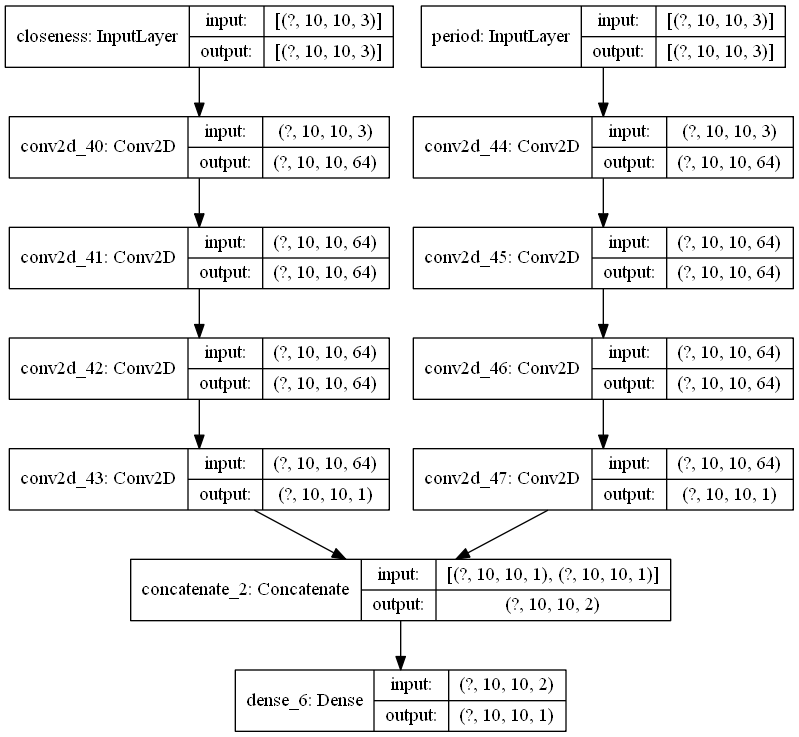

In [46]:
keras.utils.plot_model(STResNet, 'STResNet.png', show_shapes=True)

In [48]:
STResNet.compile(loss='mae', optimizer='adam')
history = STResNet.fit({'closeness': traincx, 'period': trainpx},{'dense_6':trainpy},
          epochs=50,
          batch_size=10,
          validation_data=({'closeness': testcx, 'period': testpx}, {'dense_6':testpy}))

Train on 115 samples, validate on 29 samples
Epoch 1/50
115/115 [==============================] - 2s 15ms/sample - loss: 12.2117 - val_loss: 6.6031
Epoch 2/50
115/115 [==============================] - 0s 3ms/sample - loss: 11.8378 - val_loss: 6.6745
Epoch 3/50
115/115 [==============================] - 0s 3ms/sample - loss: 11.4384 - val_loss: 6.0372
Epoch 4/50
115/115 [==============================] - 0s 3ms/sample - loss: 11.1542 - val_loss: 6.3045
Epoch 5/50
115/115 [==============================] - 0s 3ms/sample - loss: 10.9955 - val_loss: 7.8887
Epoch 6/50
115/115 [==============================] - 0s 3ms/sample - loss: 10.8128 - val_loss: 5.9422
Epoch 7/50
115/115 [==============================] - 0s 3ms/sample - loss: 10.5602 - val_loss: 6.6179
Epoch 8/50
115/115 [==============================] - 0s 4ms/sample - loss: 10.2721 - val_loss: 6.0290
Epoch 9/50
115/115 [==============================] - 0s 3ms/sample - loss: 10.1213 - val_loss: 6.5763
Epoch 10/50
115/115 [======

In [49]:
test_prediction1 = STResNet.predict({'closeness': testcx, 'period': testpx}).reshape(29,100)
testpy1 = testpy.reshape(29,100)
test_prediction1=pd.DataFrame(test_prediction1)
testpy1 = pd.DataFrame(testpy1)
list1=[]
for i in range(100):
    list1.append(mean_squared_error(testpy1.iloc[:,i], test_prediction1.iloc[:,i]))

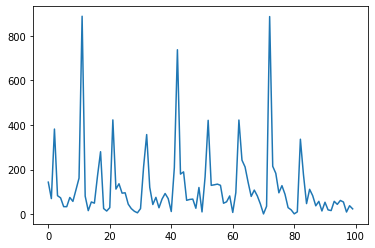

In [50]:
plt.plot(list1)

In [51]:
sum(list1)/len(list1)

122.2948118584542

In [52]:
test_prediction1.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,15.465753,6.732853,43.591713,13.846955,11.688745,7.209966,10.601830,23.221619,9.657644,13.429882,...,12.845829,5.064834,0.241057,32.382336,11.426314,21.109884,27.651966,0.241057,4.999972,4.877000
1,12.855318,14.349050,48.727707,30.525398,20.320917,5.155116,15.076032,8.167004,0.890236,16.815189,...,14.523781,9.472836,6.461468,21.101412,13.507186,24.183540,11.793378,4.679912,3.845929,1.041502
2,29.806208,12.835284,18.166044,11.282542,4.203786,12.923603,7.222326,9.340858,6.428180,13.737654,...,7.577790,0.719288,0.241057,20.863413,11.720817,9.251569,12.324683,6.935759,13.221837,3.409584
3,10.576619,4.807325,36.647438,12.252270,7.536844,6.846734,9.179848,3.303253,8.363185,21.193853,...,10.089958,5.796541,0.573133,23.769745,11.354081,12.651867,10.996237,2.178809,9.193587,7.741596
4,17.205910,11.354009,27.375786,21.364729,6.525991,8.748400,4.267169,4.452013,7.800802,18.159828,...,4.707138,1.625532,6.983030,26.862959,12.954690,5.225675,12.534599,7.156507,7.046329,5.347685


In [53]:
testpy1.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,36.0,5.0,6.0,11.0,3.0,3.0,3.0,8.0,6.0,15.0,...,11.0,0.0,3.0,28.0,6.0,19.0,9.0,2.0,10.0,13.0
1,0.0,1.0,1.0,5.0,2.0,1.0,0.0,2.0,1.0,1.0,...,3.0,1.0,0.0,12.0,3.0,5.0,4.0,1.0,2.0,4.0
2,5.0,5.0,12.0,12.0,3.0,5.0,2.0,10.0,8.0,18.0,...,7.0,4.0,2.0,21.0,17.0,10.0,11.0,3.0,12.0,8.0
3,4.0,5.0,10.0,14.0,4.0,2.0,0.0,6.0,7.0,8.0,...,15.0,5.0,0.0,28.0,12.0,11.0,10.0,3.0,22.0,16.0
4,3.0,5.0,13.0,17.0,2.0,4.0,0.0,6.0,12.0,9.0,...,14.0,7.0,0.0,30.0,16.0,11.0,14.0,3.0,15.0,5.0


In [54]:
print(scaler.data_max_)

[ 65.  46. 109.  48.  14.  37.  12.  31.  19.  53.  56. 138.  34.   9.
  22.  33.  49. 150.  16.  12.  11.  98.  13.  28.  90.  62.   6.  23.
   9.   7.  17.  59.  21.  18. 118.  15.  19.  18.  55.  25.   7.  41.
  81.  37.  19.  47.  39.  27.  17.   4.   4.  11. 176.  81.  21.  26.
  14.  47.  11.  87.   6.  54. 161.   6.   5.  34.  57.  91.  47.  60.
   8.  15. 216. 129.  52.  99.  78.  31.  18.  23.  11.  11.  55. 144.
  49.  23.  25.  36.  27.  12.  25.  14.  10. 104.  78.  34.  42.  10.
  24.  31.]


assume 30demands/30minutes are the hotspots and find whether this model can detect hotspot well

In [55]:
test_prediction_f = test_prediction1.apply(lambda x: x>=30)

In [56]:
test_prediction_f.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [57]:
testpy1_f=testpy1.apply(lambda x: x>=30)

In [72]:
accuracy_score(test_prediction_f.values.flatten(), testpy1_f.values.flatten())

0.9206896551724137

In [74]:
class ResnetIdentityBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters):
        super(ResnetIdentityBlock, self).__init__(name='')
        filters1, filters2, filters3 = filters

        self.conv2a = tf.keras.layers.Conv2D(filters1, kernel_size, padding='same')
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.conv2c = tf.keras.layers.Conv2D(filters3, kernel_size, padding='same')
        self.bn2c = tf.keras.layers.BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2b(x)
        x = self.bn2b(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2c(x)
        x = self.bn2c(x, training=training)

        x += input_tensor
        return tf.nn.relu(x)

In [76]:
closeness_input = keras.Input(shape=(10,10,3), name='closeness')
c1_input = layers.Conv2D(64, 3, activation='relu',padding='same')(closeness_input)
c1 = block(c1_input)
c1 = block(c1)
c1 = block(c1)
c1 = block(c1)
c = layers.Conv2D(1, 3, activation='relu',padding='same')(c1)

period_input = keras.Input(shape=(10,10,3), name='period')  
p1_input = layers.Conv2D(64, 3, activation='relu',padding='same')(period_input)
p1 = block(p1_input)
p1 = block(p1)
p1 = block(p1)
p1 = block(p1)
p = layers.Conv2D(1, 3, activation='relu',padding='same')(p1)

concatenated = layers.concatenate([c,p])
concatenated = layers.Dense(1)(concatenated)
concatenated = tf.nn.tanh(concatenated)

STResNet2 = keras.Model(inputs=[closeness_input,period_input],outputs=concatenated)
STResNet2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
closeness (InputLayer)          [(None, 10, 10, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 10, 10, 64)   1792        closeness[0][0]                  
__________________________________________________________________________________________________
resnet_identity_block (ResnetId (None, 10, 10, 64)   111552      conv2d_51[0][0]                  
                                                                 resnet_identity_block[0][0]      
                                                                 resnet_identity_block[1][0]      
                                                                 resnet_identity_block[2][0]

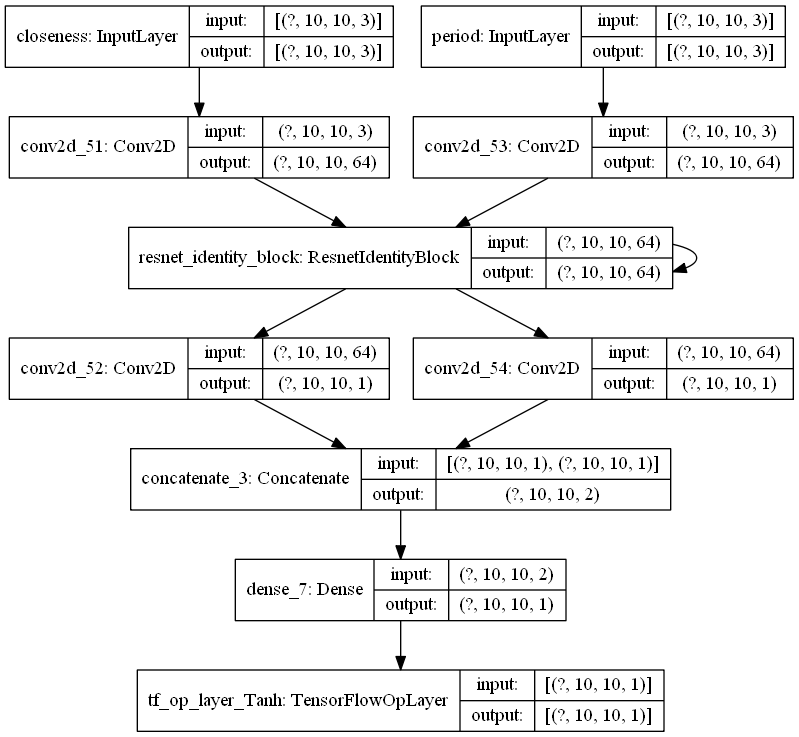

In [78]:
keras.utils.plot_model(STResNet2, 'STResNet2.png', show_shapes=True)

In [79]:
trainpy2=trainpy.reshape(115,100)
trainpy2=scaler.transform(trainpy2)
trainpy2=trainpy2.reshape(115,10,10,1)
testpy2=testpy.reshape(29,100)
testpy2=scaler.transform(testpy2)
testpy2=testpy2.reshape(29,10,10,1)

In [80]:
STResNet2.compile(loss='mae', optimizer='adam')
#history = model.fit(trainX, trainY, epochs=20, batch_size=100, verbose=2)
history = STResNet2.fit({'closeness': traincx, 'period': trainpx},{'tf_op_layer_Tanh':trainpy2},
          epochs=50,
          batch_size=10,
          validation_data=({'closeness': testcx, 'period': testpx}, {'tf_op_layer_Tanh':testpy2}))

Train on 115 samples, validate on 29 samples
Epoch 1/50
115/115 [==============================] - 6s 50ms/sample - loss: 0.4603 - val_loss: 0.1903
Epoch 2/50
115/115 [==============================] - 1s 10ms/sample - loss: 0.2810 - val_loss: 0.1720
Epoch 3/50
115/115 [==============================] - 1s 10ms/sample - loss: 0.2703 - val_loss: 0.1621
Epoch 4/50
115/115 [==============================] - 1s 10ms/sample - loss: 0.2598 - val_loss: 0.1526
Epoch 5/50
115/115 [==============================] - 1s 10ms/sample - loss: 0.2498 - val_loss: 0.1437
Epoch 6/50
115/115 [==============================] - 1s 10ms/sample - loss: 0.2403 - val_loss: 0.1357
Epoch 7/50
115/115 [==============================] - 1s 10ms/sample - loss: 0.2316 - val_loss: 0.1283
Epoch 8/50
115/115 [==============================] - 1s 10ms/sample - loss: 0.2235 - val_loss: 0.1222
Epoch 9/50
115/115 [==============================] - 1s 10ms/sample - loss: 0.2163 - val_loss: 0.1170
Epoch 10/50
115/115 [=======

In [81]:
test_prediction2 = STResNet2.predict({'closeness': testcx, 'period': testpx}).reshape(29,100)
test_prediction2 = scaler.inverse_transform(test_prediction2)
testpy1 = testpy.reshape(29,100)
test_prediction2=pd.DataFrame(test_prediction2)
testpy1 = pd.DataFrame(testpy1)
list2=[]
for i in range(100):
    list2.append(mean_squared_error(testpy1.iloc[:,i], test_prediction2.iloc[:,i]))

In [82]:
sum(list2)/len(list2)

60.213278304458505

In [83]:
test_prediction2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,16.580658,11.734004,28.5494,14.478917,3.571219,9.438221,3.061045,7.907699,4.846654,14.264527,...,6.377176,3.571219,2.55087,31.743444,21.386616,8.672959,13.693307,2.55087,6.122089,7.907699
1,16.580658,11.734004,28.5494,14.478917,3.571219,9.438221,3.061045,7.907699,4.846654,14.264527,...,6.377176,3.571219,2.55087,31.743444,21.386616,8.672959,13.693307,2.55087,6.122089,7.907699
2,16.580658,11.734004,28.5494,14.478917,3.571219,9.438221,3.061045,7.907699,4.846654,14.264527,...,6.377176,3.571219,2.55087,31.743444,21.386616,8.672959,13.693307,2.55087,6.122089,7.907699
3,16.580658,11.734004,28.5494,14.478917,3.571219,9.438221,3.061045,7.907699,4.846654,14.264527,...,6.377176,3.571219,2.55087,31.743444,21.386616,8.672959,13.693307,2.55087,6.122089,7.907699
4,16.580658,11.734004,28.5494,14.478917,3.571219,9.438221,3.061045,7.907699,4.846654,14.264527,...,6.377176,3.571219,2.55087,31.743444,21.386616,8.672959,13.693307,2.55087,6.122089,7.907699
5,16.580658,11.734004,28.5494,14.478917,3.571219,9.438221,3.061045,7.907699,4.846654,14.264527,...,6.377176,3.571219,2.55087,31.743444,21.386616,8.672959,13.693307,2.55087,6.122089,7.907699
6,16.580658,11.734004,28.5494,14.478917,3.571219,9.438221,3.061045,7.907699,4.846654,14.264527,...,6.377176,3.571219,2.55087,31.743444,21.386616,8.672959,13.693307,2.55087,6.122089,7.907699
7,16.580658,11.734004,28.5494,14.478917,3.571219,9.438221,3.061045,7.907699,4.846654,14.264527,...,6.377176,3.571219,2.55087,31.743444,21.386616,8.672959,13.693307,2.55087,6.122089,7.907699
8,16.580658,11.734004,28.5494,14.478917,3.571219,9.438221,3.061045,7.907699,4.846654,14.264527,...,6.377176,3.571219,2.55087,31.743444,21.386616,8.672959,13.693307,2.55087,6.122089,7.907699
9,16.580658,11.734004,28.5494,14.478917,3.571219,9.438221,3.061045,7.907699,4.846654,14.264527,...,6.377176,3.571219,2.55087,31.743444,21.386616,8.672959,13.693307,2.55087,6.122089,7.907699


In [84]:
test_prediction_f2 = test_prediction2.apply(lambda x: x>=30)

In [85]:
accuracy_score(test_prediction_f2.values.flatten(), testpy1_f.values.flatten())

0.9389655172413793

rmse and ability to predict hotspot is getting better but it doesn't hava a difference by the time

In [101]:
closeness_input = keras.Input(shape=(10,10,3), name='closeness')
c1_input = layers.Conv2D(64, 3, activation='relu',padding='same')(closeness_input)
c1 = block(c1_input)
c = layers.Conv2D(1, 3, activation='relu',padding='same')(c1)

period_input = keras.Input(shape=(10,10,3), name='period')  
p1_input = layers.Conv2D(64, 3, activation='relu',padding='same')(period_input)
p1 = block(p1_input)
p = layers.Conv2D(1, 3, activation='relu',padding='same')(p1)

concatenated = layers.concatenate([c,p])
concatenated = layers.Dense(1)(concatenated)
concatenated = tf.nn.tanh(concatenated)

STResNet3 = keras.Model(inputs=[closeness_input,period_input],outputs=concatenated)
STResNet3.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
closeness (InputLayer)          [(None, 10, 10, 3)]  0                                            
__________________________________________________________________________________________________
period (InputLayer)             [(None, 10, 10, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 10, 10, 64)   1792        closeness[0][0]                  
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 10, 10, 64)   1792        period[0][0]                     
____________________________________________________________________________________________

In [102]:
STResNet3.compile(loss='mae', optimizer='adam')
#history = model.fit(trainX, trainY, epochs=20, batch_size=100, verbose=2)
history = STResNet3.fit({'closeness': traincx, 'period': trainpx},{'tf_op_layer_Tanh_4':trainpy2},
          epochs=50,
          batch_size=10,
          validation_data=({'closeness': testcx, 'period': testpx}, {'tf_op_layer_Tanh_4':testpy2}))

Train on 115 samples, validate on 29 samples
Epoch 1/50
115/115 [==============================] - 2s 21ms/sample - loss: 0.3016 - val_loss: 0.1833
Epoch 2/50
115/115 [==============================] - 0s 4ms/sample - loss: 0.2754 - val_loss: 0.1724
Epoch 3/50
115/115 [==============================] - 0s 4ms/sample - loss: 0.2639 - val_loss: 0.1622
Epoch 4/50
115/115 [==============================] - 0s 4ms/sample - loss: 0.2530 - val_loss: 0.1533
Epoch 5/50
115/115 [==============================] - 0s 4ms/sample - loss: 0.2423 - val_loss: 0.1447
Epoch 6/50
115/115 [==============================] - 0s 4ms/sample - loss: 0.2336 - val_loss: 0.1368
Epoch 7/50
115/115 [==============================] - 0s 4ms/sample - loss: 0.2247 - val_loss: 0.1298
Epoch 8/50
115/115 [==============================] - 0s 4ms/sample - loss: 0.2158 - val_loss: 0.1246
Epoch 9/50
115/115 [==============================] - 0s 4ms/sample - loss: 0.2092 - val_loss: 0.1185
Epoch 10/50
115/115 [===============

In [103]:
test_prediction3 = STResNet3.predict({'closeness': testcx, 'period': testpx}).reshape(29,100)
test_prediction3 = scaler.inverse_transform(test_prediction3)
testpy1 = testpy.reshape(29,100)
test_prediction3=pd.DataFrame(test_prediction3)
testpy1 = pd.DataFrame(testpy1)
list3=[]
for i in range(100):
    list3.append(mean_squared_error(testpy1.iloc[:,i], test_prediction3.iloc[:,i]))

In [104]:
sum(list3)/len(list3)

68.35259755122614

In [105]:
test_prediction3

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,14.853117,10.511436,25.679024,13.282927,3.199133,8.454851,2.742114,7.083794,4.341680,12.882493,...,5.712737,5.717563,2.285095,29.165421,19.366720,7.769322,12.683360,2.285095,5.484228,7.083794
1,14.853117,10.511436,25.679024,13.282927,3.199133,8.454851,2.742114,7.083794,4.341680,12.882493,...,5.712737,3.199133,2.285095,29.165421,19.366720,20.903009,16.721342,2.285095,8.537554,9.848294
2,31.556185,10.511436,25.679024,13.282927,3.199133,8.454851,2.742114,7.083794,6.508335,20.942719,...,7.101115,4.338815,2.285095,29.165421,19.366720,7.769322,12.683360,2.285095,5.484228,7.083794
3,14.853117,10.511436,31.618259,16.511654,3.199133,8.454851,2.742114,7.083794,4.341680,32.708885,...,5.712737,3.199133,2.285095,29.165421,19.366720,7.769322,12.784073,2.843835,5.484228,8.697304
4,14.853117,10.511436,46.961288,13.282927,3.540708,18.671570,2.742114,7.083794,5.117452,31.600899,...,5.712737,3.199133,2.285095,32.283321,23.096624,9.751080,14.194847,2.285095,9.525496,9.251503
5,14.853117,10.511436,25.679024,13.282927,3.199133,8.454851,2.742114,7.083794,4.341680,12.882493,...,5.712737,8.103258,2.285095,29.165421,19.366720,20.582529,18.643274,2.285095,5.484228,7.083794
6,14.853117,10.511436,25.679024,13.282927,3.199133,8.454851,2.742114,7.083794,6.449828,15.375702,...,5.712737,3.199133,2.285095,29.165421,19.366720,7.769322,12.683360,2.285095,17.696445,7.083794
7,14.853117,10.511436,25.679024,13.282927,3.199133,8.454851,2.742114,7.083794,4.341680,12.882493,...,8.805945,3.199133,2.285095,29.165421,26.123430,7.769322,17.429914,2.285095,11.191973,7.083794
8,14.853117,10.511436,25.679024,13.282927,3.199133,8.454851,2.742114,7.083794,4.341680,12.882493,...,5.712737,3.199133,2.285095,33.673313,19.366720,7.769322,12.683360,2.285095,10.780355,7.083794
9,14.853117,10.511436,25.679024,13.282927,3.199133,8.454851,2.742114,7.083794,4.341680,12.882493,...,5.712737,5.607240,2.285095,29.165421,19.366720,7.769322,12.683360,2.285095,5.484228,7.083794


In [106]:
test_prediction_f3 = test_prediction3.apply(lambda x: x>=30)

In [107]:
accuracy_score(test_prediction_f3.values.flatten(), testpy1_f.values.flatten())

0.9403448275862069

in 1 layer of resnetblock, accuracy_score is getting higher and mean squared error is sligtly decreased
and we cannot see the huge difference by the time